In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier  # Use RandomForestRegressor for regression tasks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [53]:
data = pd.read_csv('certificates.csv')

C:\Users\Entwan\AppData\Local\Temp\ipykernel_21560\667726140.py:1: DtypeWarning: Columns (15,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('certificates.csv')


In [4]:
data.shape

(64698, 92)

Target column is ENERGY_CONSUMPTION_CURRENT

MemoryError: Unable to allocate 321. MiB for an array with shape (64698, 5198) and data type bool

In [5]:
data.dtypes

LMK_KEY                          object
ADDRESS1                         object
ADDRESS2                         object
ADDRESS3                         object
POSTCODE                         object
                                 ...   
TENURE                           object
FIXED_LIGHTING_OUTLETS_COUNT    float64
LOW_ENERGY_FIXED_LIGHT_COUNT    float64
UPRN                            float64
UPRN_SOURCE                      object
Length: 92, dtype: object

In [6]:
# Calculate the percentage of missing values per column
missing_percentage = data.isnull().mean() * 100

# Display columns with more than 0% missing values
print(missing_percentage[missing_percentage > 0])

ADDRESS2                         41.160469
ADDRESS3                         82.671798
BUILT_FORM                        0.055643
CONSTITUENCY                      0.029367
COUNTY                           91.531423
ENERGY_TARIFF                     0.003091
MAINS_GAS_FLAG                   16.040681
FLOOR_LEVEL                      66.855235
FLAT_TOP_STOREY                  64.804167
FLAT_STOREY_COUNT                99.703237
MAIN_HEATING_CONTROLS            92.789576
MULTI_GLAZE_PROPORTION            1.309159
GLAZED_TYPE                      14.753161
GLAZED_AREA                      14.753161
EXTENSION_COUNT                  16.040681
NUMBER_HABITABLE_ROOMS           16.040681
NUMBER_HEATED_ROOMS              16.040681
FLOOR_ENERGY_EFF                 80.467712
FLOOR_ENV_EFF                    87.678135
WINDOWS_DESCRIPTION               0.001546
WINDOWS_ENERGY_EFF                0.001546
WINDOWS_ENV_EFF                   0.001546
SECONDHEAT_DESCRIPTION           64.048348
SHEATING_EN

In [54]:
def handle_missing_values(data, threshold=0.5):
    """
    Handles missing values in a dataset:
    - Drops columns with more than a specified threshold of missing values.
    - Fills remaining missing values with median for numeric columns and mode for categorical columns.

    Parameters:
        data (pd.DataFrame): The input dataset.
        threshold (float): The proportion of missing values above which columns are dropped (default 0.5).

    Returns:
        pd.DataFrame: The cleaned dataset.
    """
    # Step 1: Drop columns with high missing values
    missing_percentage = data.isnull().mean()  # Calculate percentage of missing values
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Dropping columns with more than {threshold*100}% missing values: {list(columns_to_drop)}")
    data = data.drop(columns=columns_to_drop)

    # Step 2: Fill numeric columns with median
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_columns:
        if data[col].isnull().sum() > 0:  # Only fill if there are missing values
            data[col] = data[col].fillna(data[col].median())

    # Step 3: Fill categorical columns with mode
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        if data[col].isnull().sum() > 0:  # Only fill if there are missing values
            data[col] = data[col].fillna(data[col].mode()[0])  # Use the most frequent value

    return data

# Example usage
data = handle_missing_values(data, threshold=0.5)

# Check the result
print(data.isnull().sum())

Dropping columns with more than 50.0% missing values: ['ADDRESS3', 'COUNTY', 'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT', 'MAIN_HEATING_CONTROLS', 'FLOOR_ENERGY_EFF', 'FLOOR_ENV_EFF', 'SECONDHEAT_DESCRIPTION', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'HEAT_LOSS_CORRIDOR', 'UNHEATED_CORRIDOR_LENGTH', 'LOW_ENERGY_FIXED_LIGHT_COUNT']
LMK_KEY                         0
ADDRESS1                        0
ADDRESS2                        0
POSTCODE                        0
BUILDING_REFERENCE_NUMBER       0
                               ..
LODGEMENT_DATETIME              0
TENURE                          0
FIXED_LIGHTING_OUTLETS_COUNT    0
UPRN                            0
UPRN_SOURCE                     0
Length: 78, dtype: int64


In [55]:
# Select non-numerical columns
non_numerical_columns = data.select_dtypes(exclude=['number']).columns

# Print the non-numerical columns
print(non_numerical_columns)

Index(['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'POSTCODE', 'CURRENT_ENERGY_RATING',
       'POTENTIAL_ENERGY_RATING', 'PROPERTY_TYPE', 'BUILT_FORM',
       'INSPECTION_DATE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'LODGEMENT_DATE',
       'TRANSACTION_TYPE', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'GLAZED_TYPE',
       'GLAZED_AREA', 'HOTWATER_DESCRIPTION', 'HOT_WATER_ENERGY_EFF',
       'HOT_WATER_ENV_EFF', 'FLOOR_DESCRIPTION', 'WINDOWS_DESCRIPTION',
       'WINDOWS_ENERGY_EFF', 'WINDOWS_ENV_EFF', 'WALLS_DESCRIPTION',
       'WALLS_ENERGY_EFF', 'WALLS_ENV_EFF', 'ROOF_DESCRIPTION',
       'ROOF_ENERGY_EFF', 'ROOF_ENV_EFF', 'MAINHEAT_DESCRIPTION',
       'MAINHEAT_ENERGY_EFF', 'MAINHEAT_ENV_EFF', 'MAINHEATCONT_DESCRIPTION',
       'MAINHEATC_ENERGY_EFF', 'MAINHEATC_ENV_EFF', 'LIGHTING_DESCRIPTION',
       'LIGHTING_ENERGY_EFF', 'LIGHTING_ENV_EFF', 'MAIN_FUEL',
       'SOLAR_WATER_HEATING_FLAG', 'MECHANICAL_VENTILATION', 'ADDRESS',
       'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 'POSTTOWN',
    

Some of these columns are far unnecessary like location, unique ID and dates etc. So I am removing them.


In [56]:
columns_to_remove = ['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'POSTCODE','BUILDING_REFERENCE_NUMBER', 'INSPECTION_DATE','LOCAL_AUTHORITY',
                     'CONSTITUENCY', 'LODGEMENT_DATE', 'GLAZED_TYPE', 'GLAZED_AREA','ROOF_DESCRIPTION','ADDRESS', 'LOCAL_AUTHORITY_LABEL',
                     'CONSTITUENCY_LABEL', 'POSTTOWN', 'CONSTRUCTION_AGE_BAND',
                     'LODGEMENT_DATETIME','UPRN', 'UPRN_SOURCE']

In [57]:
# Drop the specified columns from the DataFrame
data = data.drop(columns=columns_to_remove)

In [58]:
# Inspect categorical columns and their unique values
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"Column: {col} - Unique Values: {data[col].nunique()}")

Column: CURRENT_ENERGY_RATING - Unique Values: 7
Column: POTENTIAL_ENERGY_RATING - Unique Values: 7
Column: PROPERTY_TYPE - Unique Values: 5
Column: BUILT_FORM - Unique Values: 7
Column: TRANSACTION_TYPE - Unique Values: 17
Column: ENERGY_TARIFF - Unique Values: 11
Column: MAINS_GAS_FLAG - Unique Values: 2
Column: HOTWATER_DESCRIPTION - Unique Values: 43
Column: HOT_WATER_ENERGY_EFF - Unique Values: 5
Column: HOT_WATER_ENV_EFF - Unique Values: 5
Column: FLOOR_DESCRIPTION - Unique Values: 105
Column: WINDOWS_DESCRIPTION - Unique Values: 17
Column: WINDOWS_ENERGY_EFF - Unique Values: 5
Column: WINDOWS_ENV_EFF - Unique Values: 5
Column: WALLS_DESCRIPTION - Unique Values: 141
Column: WALLS_ENERGY_EFF - Unique Values: 5
Column: WALLS_ENV_EFF - Unique Values: 5
Column: ROOF_ENERGY_EFF - Unique Values: 5
Column: ROOF_ENV_EFF - Unique Values: 5
Column: MAINHEAT_DESCRIPTION - Unique Values: 169
Column: MAINHEAT_ENERGY_EFF - Unique Values: 5
Column: MAINHEAT_ENV_EFF - Unique Values: 5
Column: MA

Columns with too many unique values (e.g., free-form text, long identifiers) might be less useful for encoding because encoding them could lead to a high-dimensional feature space, which can hurt model performance. You can filter out columns with too many unique values by setting a threshold for cardinality:

In [59]:
# Filter categorical columns with too many unique values (e.g., more than 20)
high_cardinality_cols = [col for col in categorical_columns if data[col].nunique() > 20]
print(f"High Cardinality Columns: {high_cardinality_cols}")

High Cardinality Columns: ['HOTWATER_DESCRIPTION', 'FLOOR_DESCRIPTION', 'WALLS_DESCRIPTION', 'MAINHEAT_DESCRIPTION', 'MAINHEATCONT_DESCRIPTION', 'LIGHTING_DESCRIPTION', 'MAIN_FUEL']


In [60]:
data = data.drop(columns=high_cardinality_cols)

In [61]:
data.shape

(64698, 51)

For categorical features with many levels, you can group the less frequent categories into an "Other" or "Unknown" category.

For example, if a column like PROPERTY_TYPE has categories like "detached", "semi-detached", "apartment", etc., but a few categories have very few entries, you could merge those into a single "Other" category.

In [62]:
# Group categories with fewer than a threshold number of occurrences
threshold = 10  # Set the threshold based on your data

# Get categorical columns present in the current DataFrame
categorical_columns_present = data.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns_present:  # Iterate through columns present in the DataFrame
    value_counts = data[col].value_counts()
    low_frequency_values = value_counts[value_counts < threshold].index
    data[col] = data[col].replace(low_frequency_values, 'Other')

3. Use Label Encoding for High Cardinality Features
For categorical columns with high cardinality, instead of applying OneHotEncoding, you can apply Label Encoding (i.e., assigning each category a unique integer). This works well for ordinal categorical features (where the categories have a meaningful order), but it can also be useful for reducing dimensionality

In [63]:
from sklearn.preprocessing import LabelEncoder

# Get categorical columns present in the current DataFrame
categorical_columns_present = data.select_dtypes(include=['object', 'category']).columns

label_encoder = LabelEncoder()
for col in categorical_columns_present:  # Use updated categorical columns
    if data[col].nunique() <= 20:  # Only apply to columns with fewer unique values
        data[col] = label_encoder.fit_transform(data[col])

In [64]:
# Apply target encoding (mean encoding) to categorical columns
# Get the current categorical columns
categorical_columns_present = data.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns_present:  # Iterate through the updated columns
    if data[col].nunique() <= 20:  # Only apply to columns with fewer unique values
        mean_encoded = data.groupby(col)['ENERGY_CONSUMPTION_CURRENT'].mean()
        data[col] = data[col].map(mean_encoded)

5. Feature Importance with RandomForest (For Selection)
Once you've reduced the dimensions by dropping or encoding categorical features, you can use RandomForest to calculate feature importance. This will help you identify which features (both numerical and categorical) are most important for predicting the target variable.

In [65]:
# Split the data into features and target
X = data.drop(columns=['ENERGY_CONSUMPTION_CURRENT'])  # Replace with your target column name
y = data['ENERGY_CONSUMPTION_CURRENT']

# Identify numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns

# Keep only numeric columns
X = X[numeric_columns]

In [19]:
from sklearn.ensemble import RandomForestRegressor
# Train RandomForest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Show the top important features
print(feature_importance_df.head(30))

                          Feature  Importance
11  CO2_EMISS_CURR_PER_FLOOR_AREA    0.655375
9    ENERGY_CONSUMPTION_POTENTIAL    0.176281
10          CO2_EMISSIONS_CURRENT    0.058435
12        CO2_EMISSIONS_POTENTIAL    0.047690
8    ENVIRONMENT_IMPACT_POTENTIAL    0.032374
38               MAINHEAT_ENV_EFF    0.010397
37            MAINHEAT_ENERGY_EFF    0.003122
2       CURRENT_ENERGY_EFFICIENCY    0.002306
13          LIGHTING_COST_CURRENT    0.001503
21                 MAINS_GAS_FLAG    0.001394
29              HOT_WATER_ENV_EFF    0.001157
44                   FLOOR_HEIGHT    0.001032
3     POTENTIAL_ENERGY_EFFICIENCY    0.000726
0           CURRENT_ENERGY_RATING    0.000685
17         HOT_WATER_COST_CURRENT    0.000584
39           MAINHEATC_ENERGY_EFF    0.000544
19               TOTAL_FLOOR_AREA    0.000482
34                  WALLS_ENV_EFF    0.000465
14        LIGHTING_COST_POTENTIAL    0.000454
18       HOT_WATER_COST_POTENTIAL    0.000440
7      ENVIRONMENT_IMPACT_CURRENT 

In [66]:
# List of top 15 important features (based on previous steps)
top_features = [
    'CO2_EMISS_CURR_PER_FLOOR_AREA', 'ENERGY_CONSUMPTION_POTENTIAL',
    'CO2_EMISSIONS_CURRENT', 'CO2_EMISSIONS_POTENTIAL', 'ENVIRONMENT_IMPACT_POTENTIAL',
    'MAINHEAT_ENV_EFF', 'MAINHEAT_ENERGY_EFF', 'CURRENT_ENERGY_EFFICIENCY',
    'LIGHTING_COST_CURRENT',
    'MAINS_GAS_FLAG', 'HOT_WATER_ENV_EFF',
    'FLOOR_HEIGHT', 'POTENTIAL_ENERGY_EFFICIENCY',
    'CURRENT_ENERGY_RATING', 'HOT_WATER_COST_CURRENT', 'MAINHEATC_ENERGY_EFF',
    'ENERGY_CONSUMPTION_CURRENT'
]

# Select only the top 15 important columns in your data
data_reduced = data[top_features]

# Verify the reduced dataset
print("Shape of reduced dataset:", data_reduced.shape)
print("Columns in reduced dataset:", data_reduced.columns)

Shape of reduced dataset: (64698, 17)
Columns in reduced dataset: Index(['CO2_EMISS_CURR_PER_FLOOR_AREA', 'ENERGY_CONSUMPTION_POTENTIAL',
       'CO2_EMISSIONS_CURRENT', 'CO2_EMISSIONS_POTENTIAL',
       'ENVIRONMENT_IMPACT_POTENTIAL', 'MAINHEAT_ENV_EFF',
       'MAINHEAT_ENERGY_EFF', 'CURRENT_ENERGY_EFFICIENCY',
       'LIGHTING_COST_CURRENT', 'MAINS_GAS_FLAG', 'HOT_WATER_ENV_EFF',
       'FLOOR_HEIGHT', 'POTENTIAL_ENERGY_EFFICIENCY', 'CURRENT_ENERGY_RATING',
       'HOT_WATER_COST_CURRENT', 'MAINHEATC_ENERGY_EFF',
       'ENERGY_CONSUMPTION_CURRENT'],
      dtype='object')


In [67]:
data_reduced.head()

,CO2_EMISS_CURR_PER_FLOOR_AREA,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISSIONS_POTENTIAL,ENVIRONMENT_IMPACT_POTENTIAL,MAINHEAT_ENV_EFF,MAINHEAT_ENERGY_EFF,CURRENT_ENERGY_EFFICIENCY,LIGHTING_COST_CURRENT,MAINS_GAS_FLAG,HOT_WATER_ENV_EFF,FLOOR_HEIGHT,POTENTIAL_ENERGY_EFFICIENCY,CURRENT_ENERGY_RATING,HOT_WATER_COST_CURRENT,MAINHEATC_ENERGY_EFF,ENERGY_CONSUMPTION_CURRENT
0,31,178,1.9,1.9,75,1,1,75,58,1,1,2.40,75,2,80,1,178
1,58,154,4.0,1.9,77,1,1,57,87,1,2,2.40,76,3,369,0,331
2,35,78,3.1,1.2,86,1,1,71,71,1,1,2.24,87,2,142,0,201
3,50,160,9.2,5.2,65,1,1,50,181,1,1,2.37,71,4,137,0,284
4,38,148,2.9,2.0,78,1,1,70,65,1,1,2.33,78,2,166,1,217


Feature selection: Based on the importance scores, you could apply feature selection techniques (e.g., SelectFromModel in scikit-learn) to automatically discard features with low importance.

In [68]:
data_reduced.dtypes

CO2_EMISS_CURR_PER_FLOOR_AREA      int64
ENERGY_CONSUMPTION_POTENTIAL       int64
CO2_EMISSIONS_CURRENT            float64
CO2_EMISSIONS_POTENTIAL          float64
ENVIRONMENT_IMPACT_POTENTIAL       int64
MAINHEAT_ENV_EFF                   int32
MAINHEAT_ENERGY_EFF                int32
CURRENT_ENERGY_EFFICIENCY          int64
LIGHTING_COST_CURRENT              int64
MAINS_GAS_FLAG                     int32
HOT_WATER_ENV_EFF                  int32
FLOOR_HEIGHT                     float64
POTENTIAL_ENERGY_EFFICIENCY        int64
CURRENT_ENERGY_RATING              int32
HOT_WATER_COST_CURRENT             int64
MAINHEATC_ENERGY_EFF               int32
ENERGY_CONSUMPTION_CURRENT         int64
dtype: object

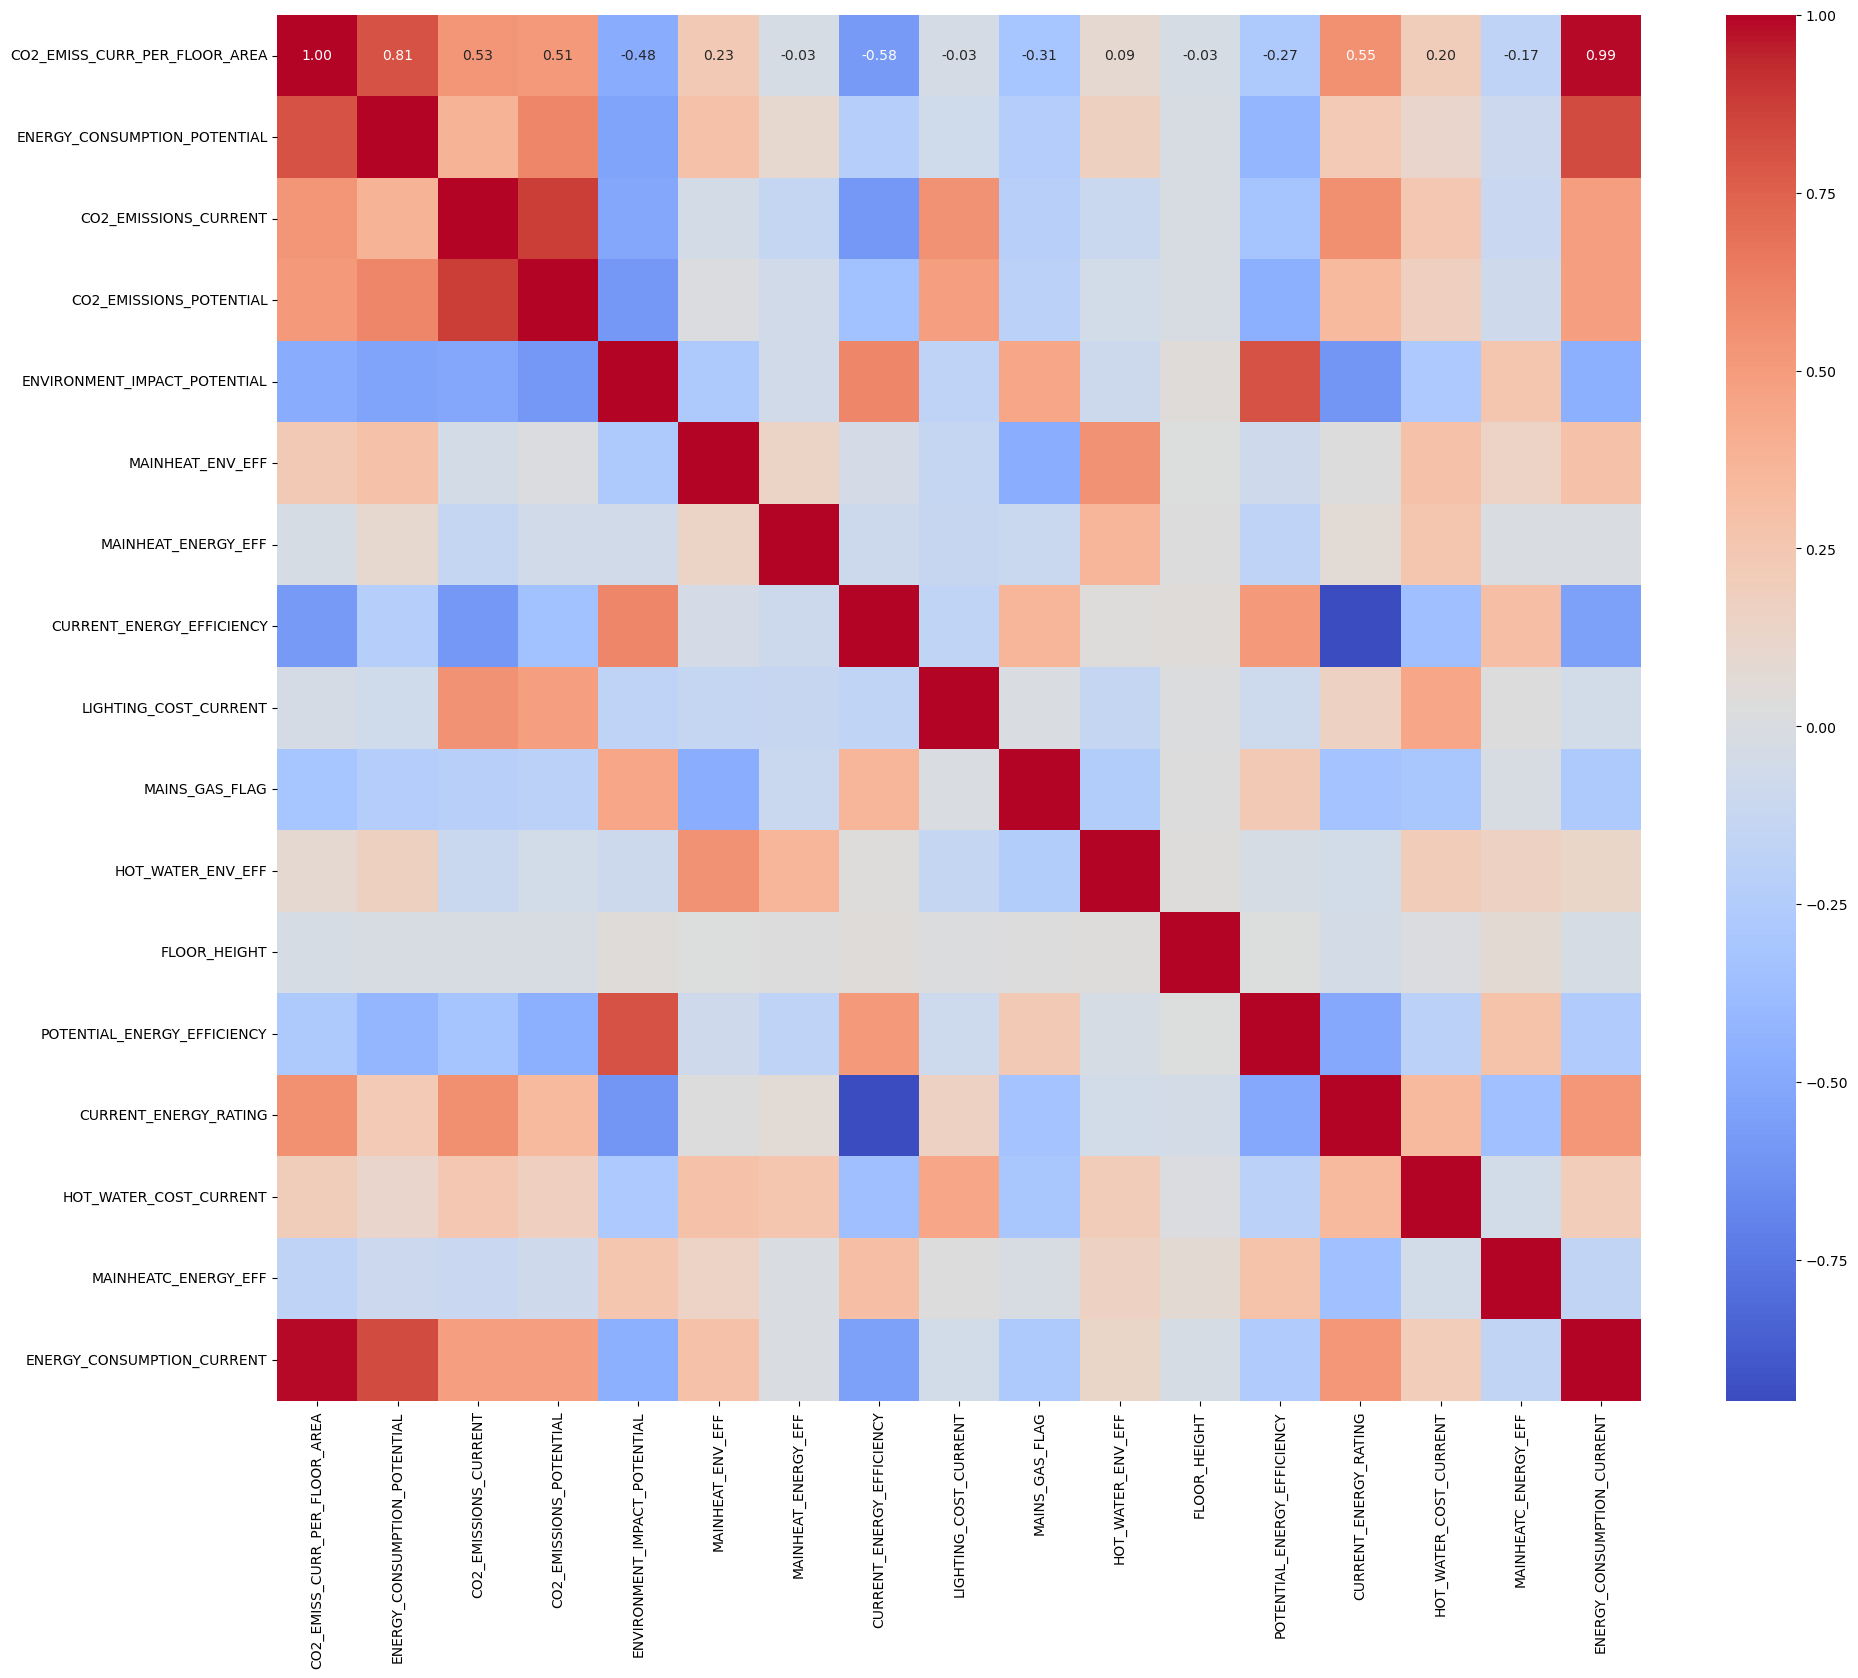

In [69]:
correlation_matrix = data_reduced.corr()

# Plot the heatmap
plt.figure(figsize=(22, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

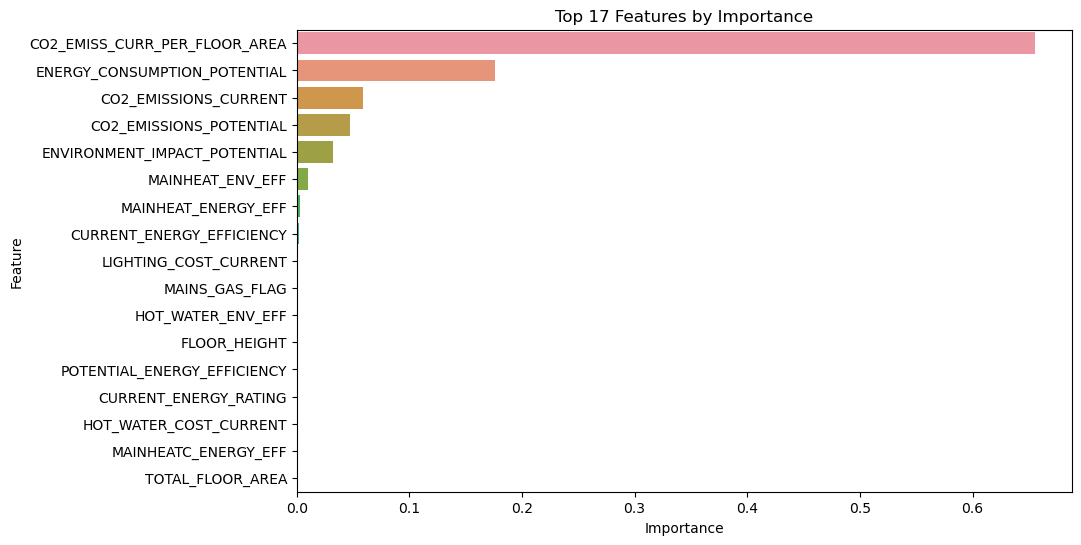

In [70]:
# Assuming 'feature_importance_df' has been created earlier
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(17))
plt.title('Top 17 Features by Importance')
plt.show()

c:\Users\Entwan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


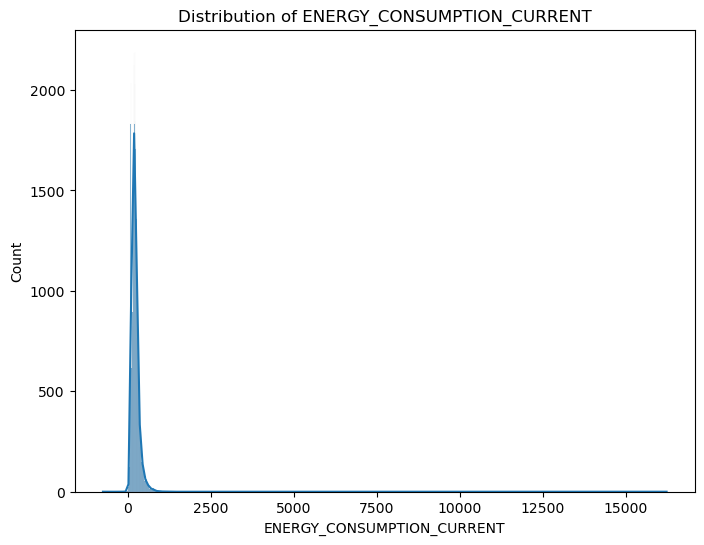

In [71]:

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(data_reduced['ENERGY_CONSUMPTION_CURRENT'], kde=True)
plt.title('Distribution of ENERGY_CONSUMPTION_CURRENT')
plt.show()

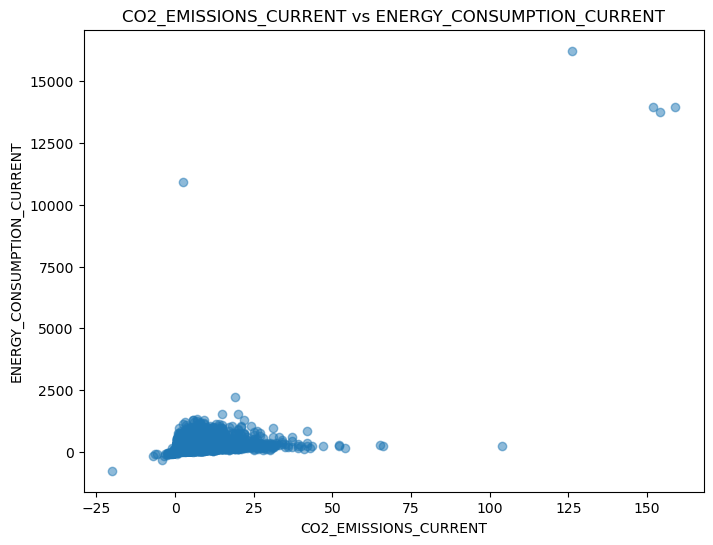

In [72]:
# Example: Plot a scatter plot for a selected feature against the target
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced['CO2_EMISSIONS_CURRENT'], data_reduced['ENERGY_CONSUMPTION_CURRENT'], alpha=0.5)
plt.title('CO2_EMISSIONS_CURRENT vs ENERGY_CONSUMPTION_CURRENT')
plt.xlabel('CO2_EMISSIONS_CURRENT')
plt.ylabel('ENERGY_CONSUMPTION_CURRENT')
plt.show()

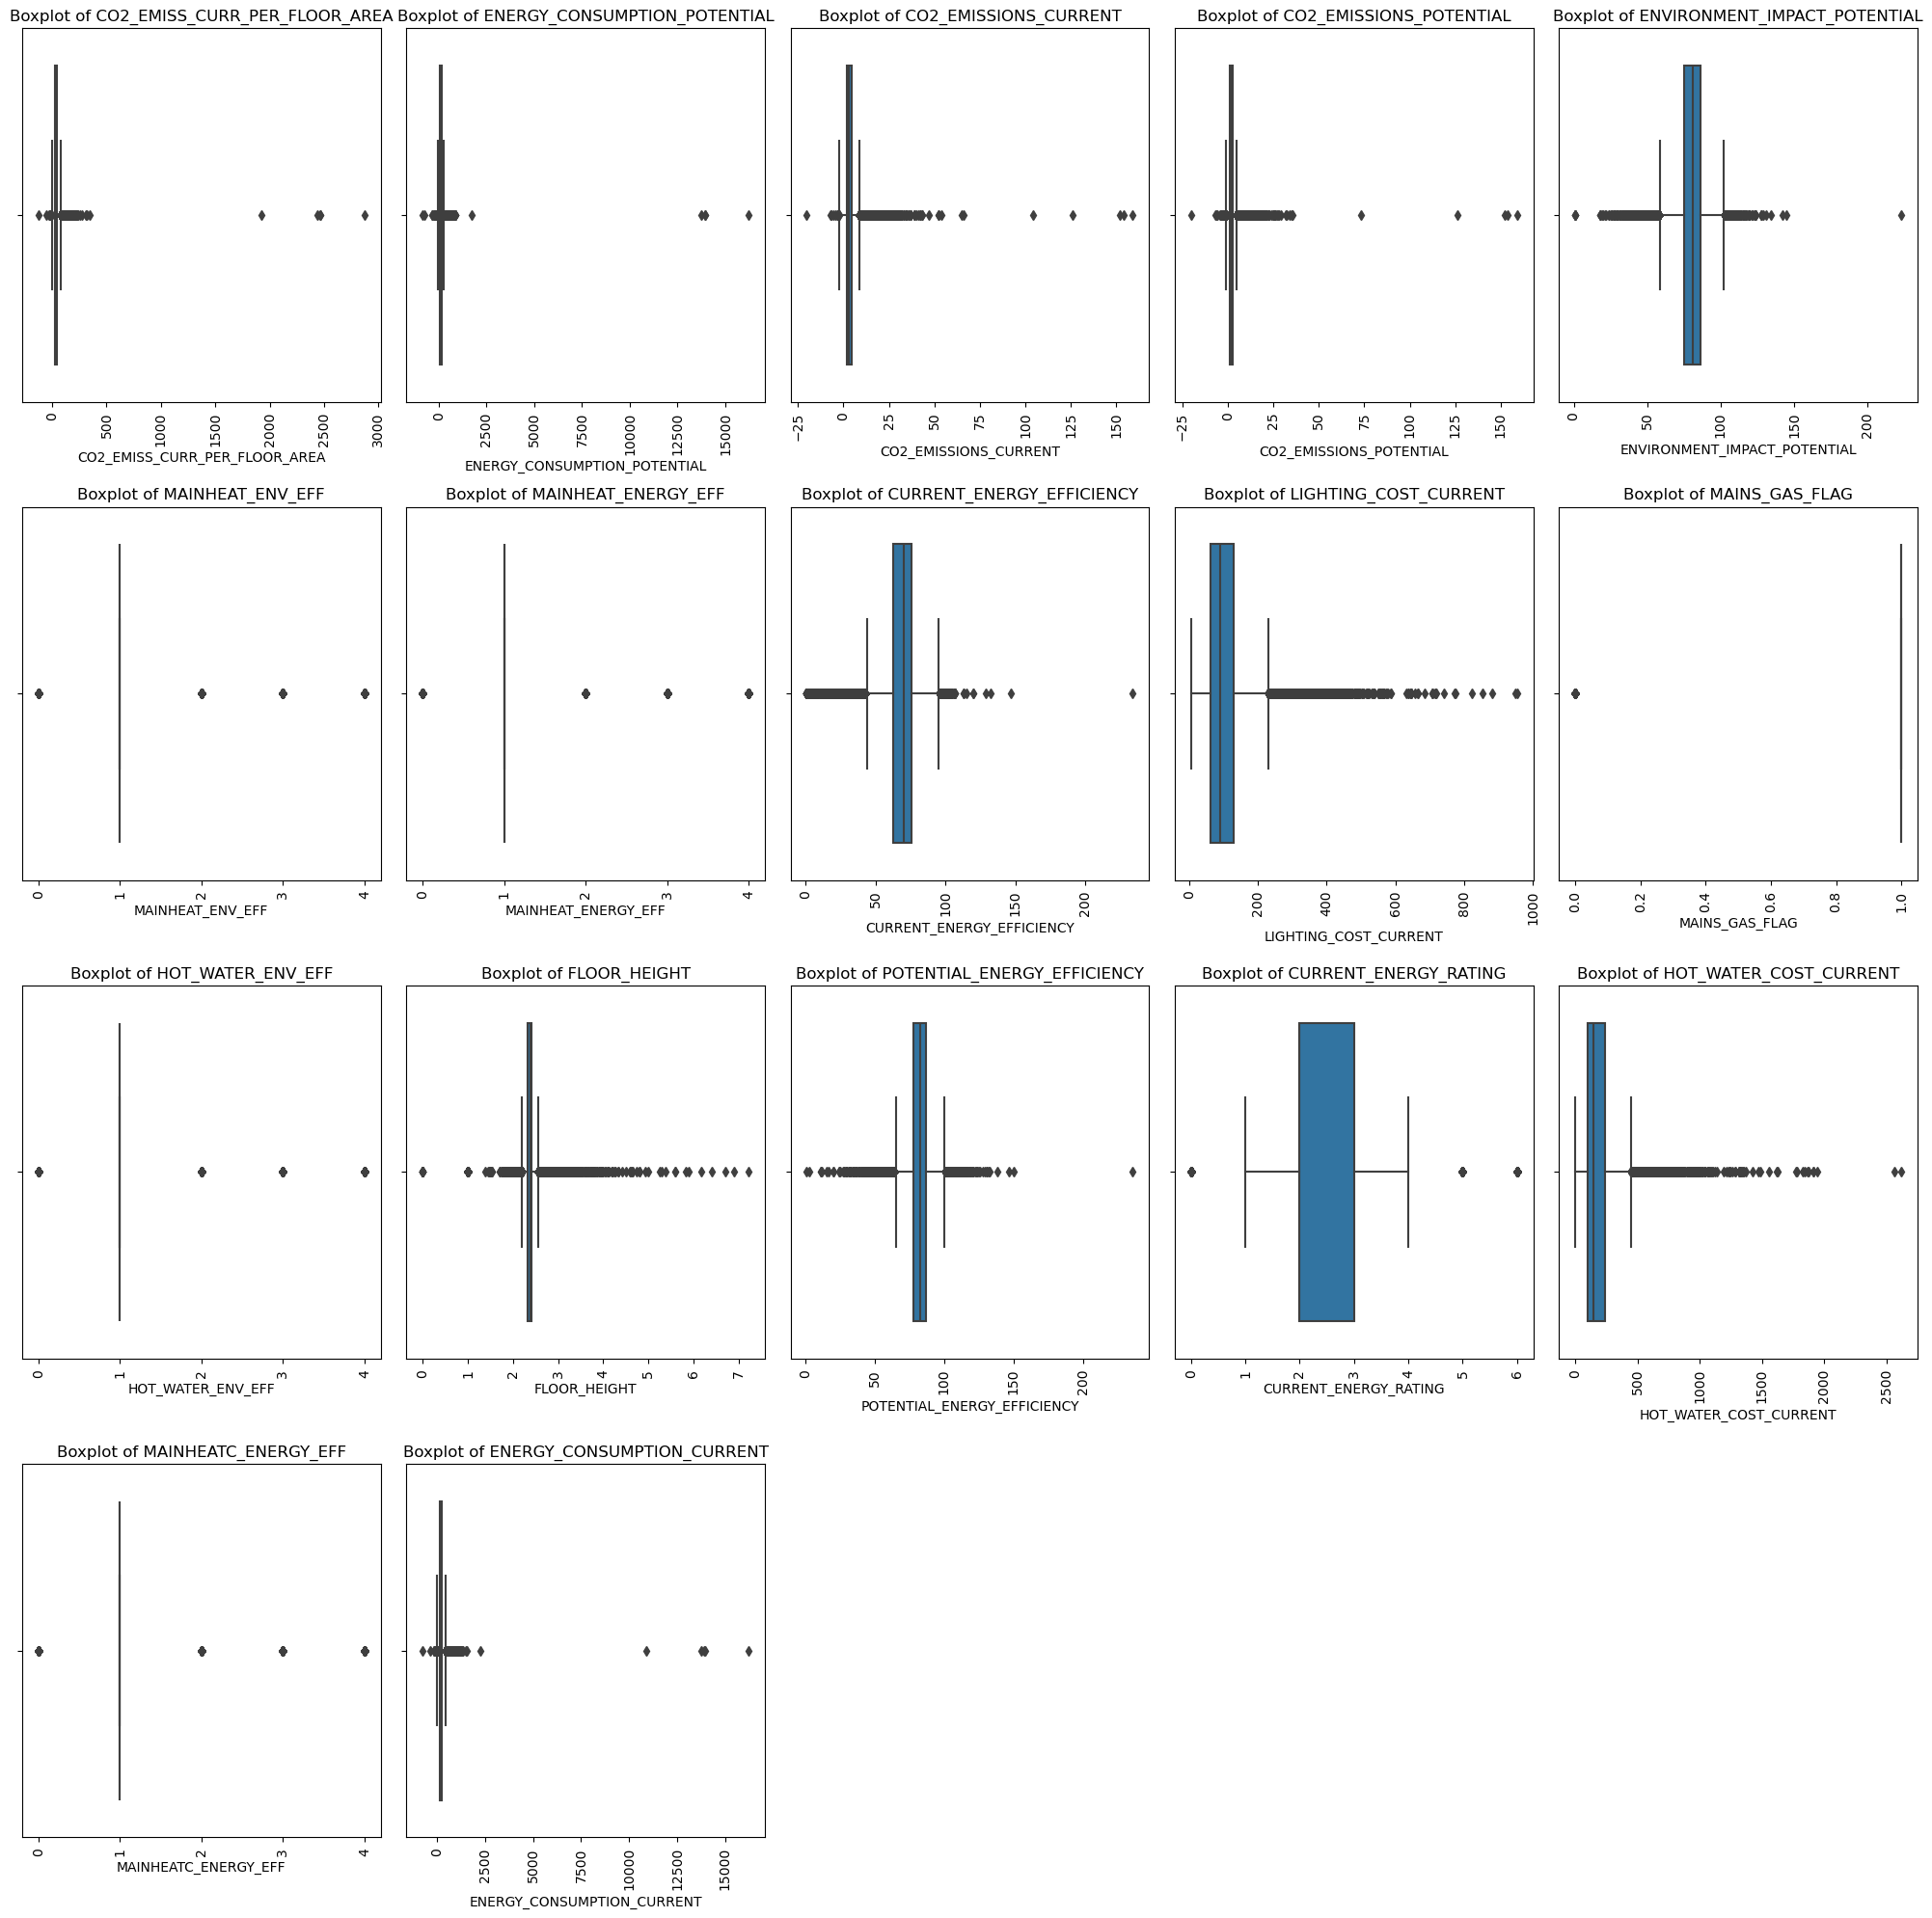

In [73]:
# Get numeric columns for plotting
numeric_columns = data_reduced.columns

# Set the number of columns and rows for the subplot grid
n_cols = 5  # Adjust based on how many plots you have
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

# Create a large plot with subplots
plt.figure(figsize=(20, 5 * n_rows))  # Adjust the size as needed

# Iterate over each column and create a boxplot
for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)  # Create subplot in a grid
    sns.boxplot(x=data_reduced[col])  # Plot boxplot for the column
    plt.title(f'Boxplot of {col}')  # Add title to each plot
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if necessary

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [74]:
data_reduced.head(10)

,CO2_EMISS_CURR_PER_FLOOR_AREA,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISSIONS_POTENTIAL,ENVIRONMENT_IMPACT_POTENTIAL,MAINHEAT_ENV_EFF,MAINHEAT_ENERGY_EFF,CURRENT_ENERGY_EFFICIENCY,LIGHTING_COST_CURRENT,MAINS_GAS_FLAG,HOT_WATER_ENV_EFF,FLOOR_HEIGHT,POTENTIAL_ENERGY_EFFICIENCY,CURRENT_ENERGY_RATING,HOT_WATER_COST_CURRENT,MAINHEATC_ENERGY_EFF,ENERGY_CONSUMPTION_CURRENT
0,31,178,1.9,1.9,75,1,1,75,58,1,1,2.40,75,2,80,1,178
1,58,154,4.0,1.9,77,1,1,57,87,1,2,2.40,76,3,369,0,331
2,35,78,3.1,1.2,86,1,1,71,71,1,1,2.24,87,2,142,0,201
3,50,160,9.2,5.2,65,1,1,50,181,1,1,2.37,71,4,137,0,284
4,38,148,2.9,2.0,78,1,1,70,65,1,1,2.33,78,2,166,1,217
5,33,123,4.3,2.8,76,1,1,70,85,1,1,2.40,81,2,107,1,189
6,31,98,3.1,1.8,79,1,1,71,83,1,1,2.39,83,2,85,1,175
7,72,265,4.9,3.1,60,2,4,42,68,0,2,2.44,75,4,221,1,425
8,32,-25,2.7,-0.5,102,1,1,69,98,1,1,4.10,104,2,90,1,198
9,36,74,2.4,0.9,88,1,1,71,93,1,1,2.31,88,2,127,1,202


In [76]:
# Function to remove outliers using IQR
def remove_outliers_iqr(data):
    """
    Removes outliers from a dataset using the IQR method.
    
    Parameters:
        data (pd.DataFrame): The dataset to clean.
        
    Returns:
        pd.DataFrame: The cleaned dataset without outliers.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for numeric columns
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a mask for rows within the bounds for all numeric features
    mask = ~((data < lower_bound) | (data > upper_bound)).any(axis=1)

    # Apply the mask to the dataset
    data_cleaned = data[mask]

    return data_cleaned

# Apply outlier removal to data_reduced
data_cleaned = remove_outliers_iqr(data_reduced)

# Verify the results
print(f"Shape of data_reduced before outlier removal: {data_reduced.shape}")
print(f"Shape of data_cleaned after outlier removal: {data_cleaned.shape}")
print(f"Missing values in data_cleaned: {data_cleaned.isnull().sum().sum()}")

Shape of data_reduced before outlier removal: (64698, 17)
Shape of data_cleaned after outlier removal: (27645, 17)
Missing values in data_cleaned: 0


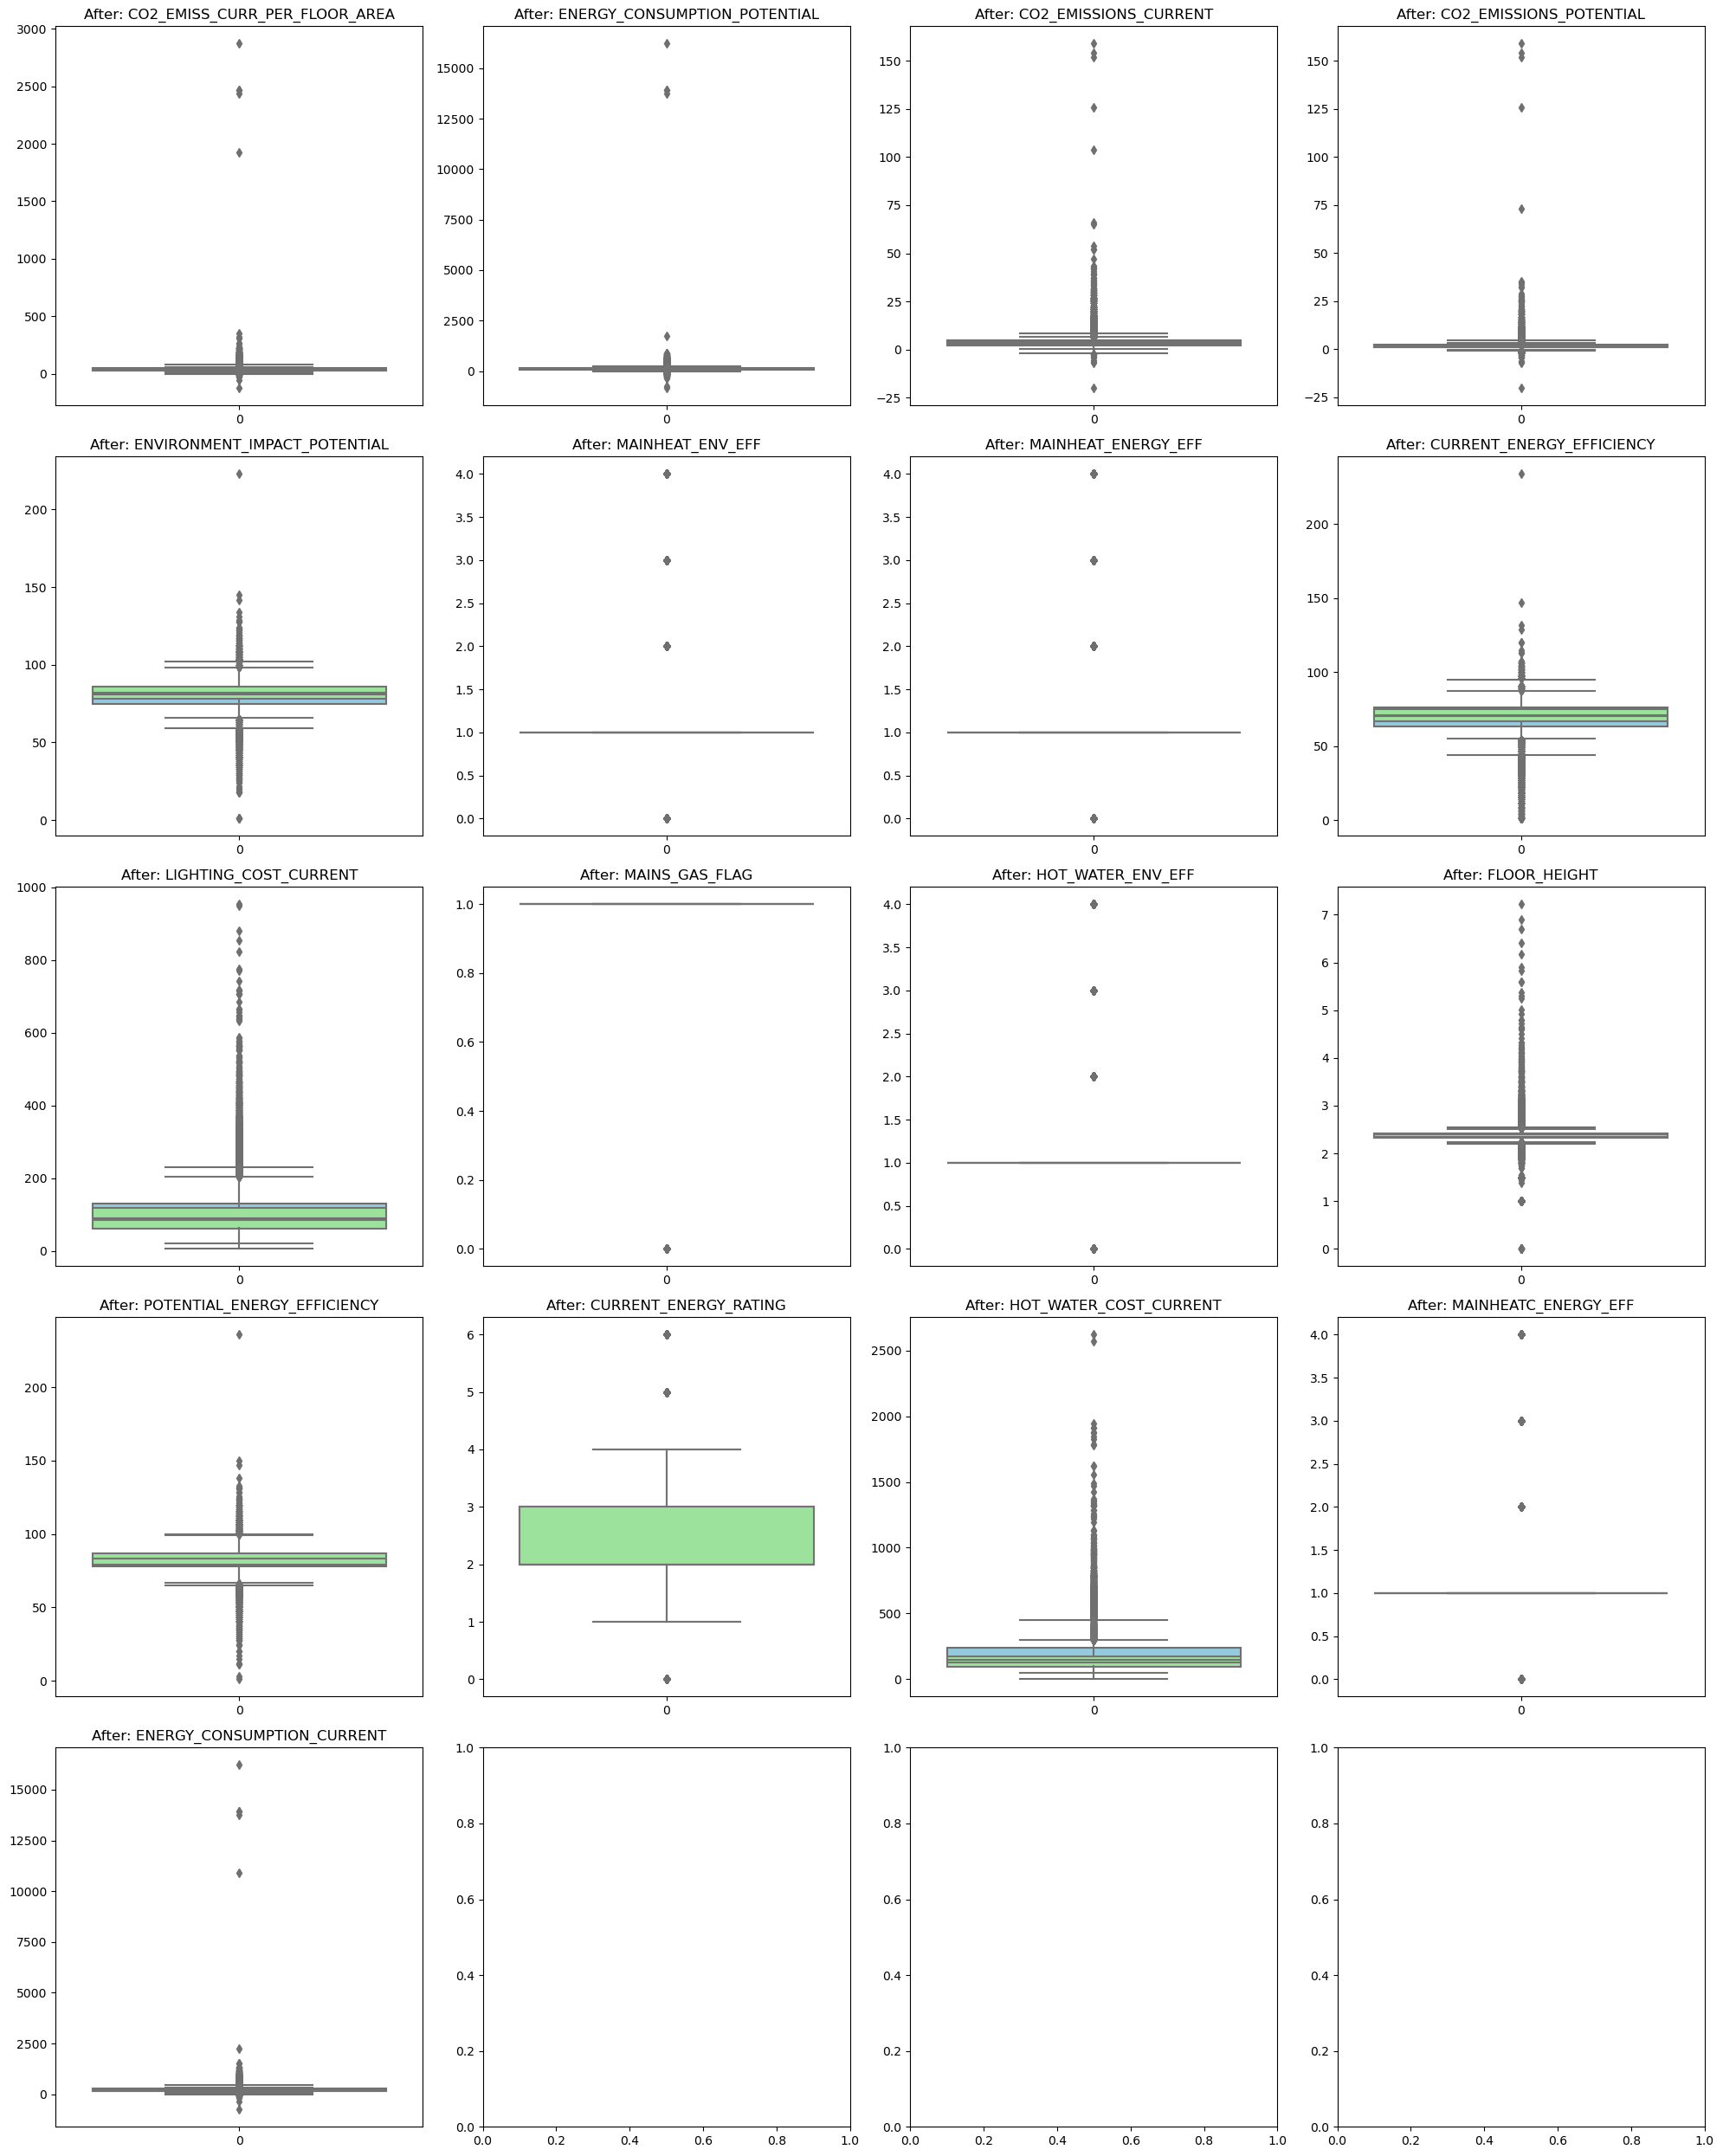

In [77]:
# Select numeric columns for plotting
numeric_columns = data_reduced.select_dtypes(include=['number']).columns

# Plot box plots before and after outlier removal
n_cols = 4  # Number of plots per row
n_rows = int(np.ceil(len(numeric_columns) / n_cols))  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Iterate over numeric columns and create box plots
for i, col in enumerate(numeric_columns):
    row, col_idx = divmod(i, n_cols)  # Get subplot grid position
    
    # Plot original data
    sns.boxplot(data=data_reduced[col], ax=axes[row, col_idx], color='skyblue')
    axes[row, col_idx].set_title(f'Before: {col}')
    
    # Overlay cleaned data
    sns.boxplot(data=data_cleaned[col], ax=axes[row, col_idx], color='lightgreen')
    axes[row, col_idx].set_title(f'After: {col}')
    
# Adjust layout
plt.tight_layout()
plt.show()

In [78]:
# Prepare features (X) and target (y)
X = data_cleaned.drop(columns=['ENERGY_CONSUMPTION_CURRENT'])  # Features
y = data_cleaned['ENERGY_CONSUMPTION_CURRENT']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Dictionary to store results
results = {}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store the results
    results[model_name] = {"R²": r2, "MAE": mae, "RMSE": rmse}

# Convert results to a DataFrame for easier comparison
results_df = pd.DataFrame(results).T

# Display the results
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                         R²       MAE       RMSE
Linear Regression  0.995329  2.731880   3.896621
Random Forest      0.994196  2.201722   4.343693
Gradient Boosting  0.994969  2.360214   4.044151
SVR                0.962507  7.016445  11.039990
KNN                0.943936  8.842576  13.500115


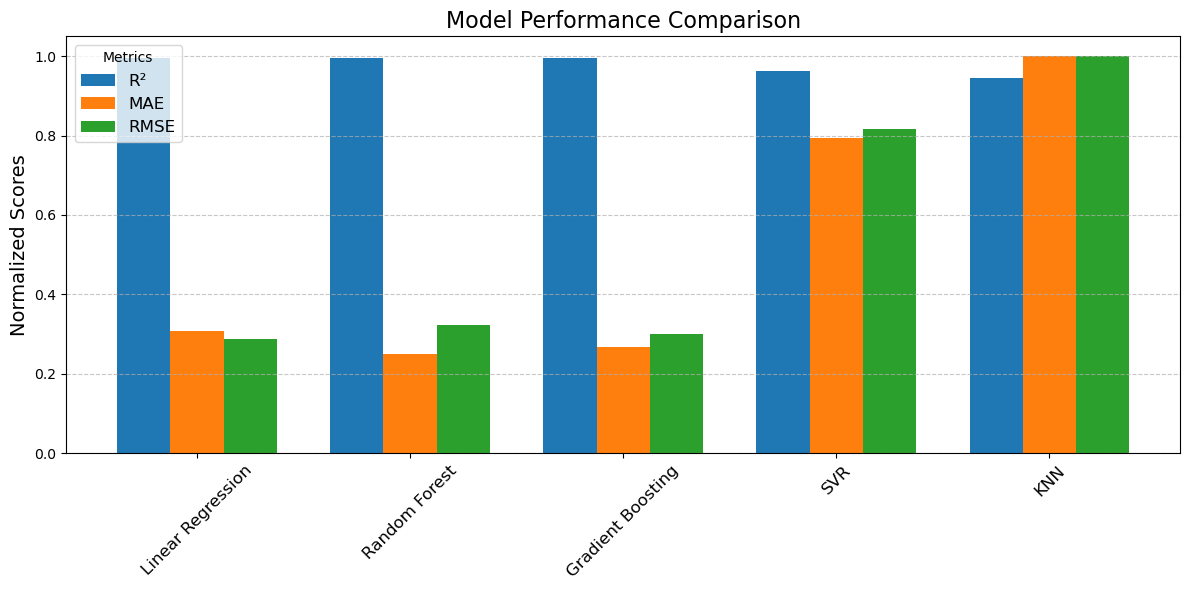

In [80]:
# Normalize the metrics for combined visualization
normalized_results = results_df.copy()
normalized_results['MAE'] = normalized_results['MAE'] / normalized_results['MAE'].max()  # Scale MAE
normalized_results['RMSE'] = normalized_results['RMSE'] / normalized_results['RMSE'].max()  # Scale RMSE

# Plot the normalized metrics
metrics = ['R²', 'MAE', 'RMSE']
x = np.arange(len(results_df.index))  # Number of models
width = 0.25  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Add bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, normalized_results[metric], width, label=metric)

# Add labels, title, and legend
ax.set_xticks(x + width)
ax.set_xticklabels(results_df.index, rotation=45, fontsize=12)
ax.set_ylabel('Normalized Scores', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.legend(title="Metrics", fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()